In [34]:
import pandas as pd
from scipy.stats import norm
import numpy as np
import plotly.graph_objs as go
import plotly.express as px
import pystable

In [88]:
from IPython.display import Image
interact_chart = False

# Get Data

Coinbase data (treated)

In [36]:
coin_df = pd.read_csv('risk_pipeline/outputs/data/ETH-BTC_2022-06-01-00-00_2022-10-31-00-00_600secs_treated.csv', index_col=0)

In [37]:
coin_df.head()

,time,close
0,2022-06-01 00:00:00,0.061110
1,2022-06-01 00:10:00,0.061075
2,2022-06-01 00:20:00,0.060915
3,2022-06-01 00:30:00,0.060985
4,2022-06-01 00:40:00,0.061020


In [38]:
# invert close to match uni v3
coin_df.close = 1/coin_df.close

Uniswap data

In [39]:
uni_df = pd.read_csv('../csv/WBTC-WETH-10.0mTWAP-14881677-to-15864319.csv', index_col=0)

In [40]:
uni_df.head()

,timestamp,twap
0,2022-06-01 00:01:54,16.335589
2,2022-06-01 00:11:54,16.345683
4,2022-06-01 00:21:54,16.351692
10,2022-06-01 00:31:54,16.361773
11,2022-06-01 00:41:54,16.366600


In [41]:
uni_df.reset_index(inplace=True)

# Sanity checks

In [42]:
uni_df[uni_df.twap.isna()]

,index,timestamp,twap


In [43]:
coin_df[coin_df.close.isna()]

,time,close


In [44]:
print('shape:', uni_df.shape)
print('first timestamp:', uni_df.timestamp.min())
print('last timestamp:', uni_df.timestamp.max())

shape: (21883, 3)
first timestamp: 2022-06-01 00:01:54
last timestamp: 2022-10-30 23:01:54


In [45]:
print('shape:', coin_df.shape)
print('first timestamp:', coin_df.time.min())
print('last timestamp:', coin_df.time.max())

shape: (21889, 2)
first timestamp: 2022-06-01 00:00:00
last timestamp: 2022-10-31 00:00:00


# Combine data

In [46]:
df = pd.concat([coin_df.time, coin_df.close, uni_df.twap], axis=1)

In [47]:
df

,time,close,twap
0,2022-06-01 00:00:00,16.363934,16.335589
1,2022-06-01 00:10:00,16.373312,16.345683
2,2022-06-01 00:20:00,16.416318,16.351692
3,2022-06-01 00:30:00,16.397475,16.361773
4,2022-06-01 00:40:00,16.388069,16.366600
...,...,...,...
21884,2022-10-30 23:20:00,12.971010,NaN
21885,2022-10-30 23:30:00,12.965124,NaN
21886,2022-10-30 23:40:00,12.977743,NaN
21887,2022-10-30 23:50:00,12.965964,NaN


In [48]:
# Change column names
df.columns = ['time', 'coin', 'uni']

In [49]:
print('NAs in coinbase column =', df[df.coin.isna()].count()[0])
print('NAs in uniswap column =', df[df.uni.isna()].count()[0])


NAs in coinbase column = 0
NAs in uniswap column = 6


In [50]:
df.dropna(inplace=True)

In [51]:
df

,time,coin,uni
0,2022-06-01 00:00:00,16.363934,16.335589
1,2022-06-01 00:10:00,16.373312,16.345683
2,2022-06-01 00:20:00,16.416318,16.351692
3,2022-06-01 00:30:00,16.397475,16.361773
4,2022-06-01 00:40:00,16.388069,16.366600
...,...,...,...
21878,2022-10-30 22:20:00,13.005592,12.995307
21879,2022-10-30 22:30:00,12.997141,12.995306
21880,2022-10-30 22:40:00,12.990387,12.995304
21881,2022-10-30 22:50:00,12.971851,12.995304


# Analysis

In [90]:
def line_chart(df, title, xcol, ycol, x_title, y_title):
    fig = px.line(df, x=xcol, y=ycol)
    fig.update_layout(title=title)
    fig.update_layout(xaxis_title=x_title, yaxis_title=y_title)
    return fig

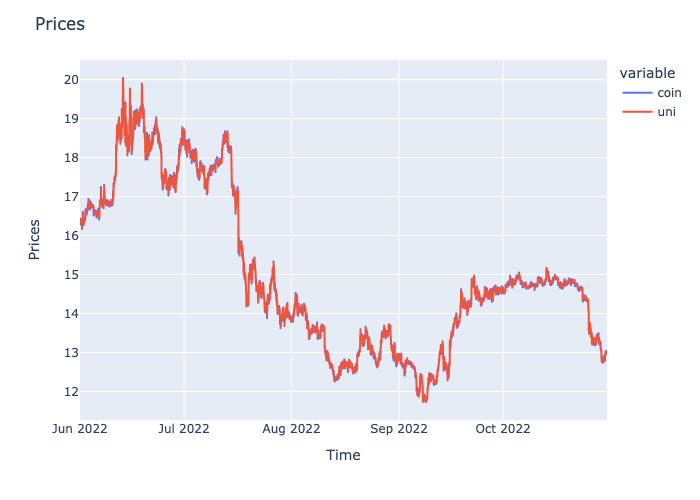

In [89]:
# Superimposed plot
plt = line_chart(df, 'Prices', 'time', ['coin', 'uni'], 'Time', 'Prices')
plt.show() if interact_chart else Image(plt.to_image(format="png"))

In [56]:
# Pystable funcs

def gaussian():
    return pystable.create(alpha=2.0, beta=0.0, mu=0.0,
                           sigma=1.0, parameterization=1)

def get_qs(dst):
    l = [i/100 for i in range(1, 100, 1)]
    return pystable.q(dst, l, len(l))

def pdf(dst, vals):
    return pystable.pdf(dst, vals, len(vals))

def log_returns(p):
    return [np.log(p[i]/p[i-1]) for i in range(1, len(p))]


In [57]:
# Data funcs
def get_qs_data(series):
    l = [i for i in range(1, 100, 1)]
    return [np.percentile(series, i) for i in l]

In [58]:
log_coin = log_returns(df['coin'])
log_uni = log_returns(df['uni'])

In [59]:
dst_coin = gaussian()
pystable.fit(dst_coin, log_coin, len(log_coin))

dst_uni = gaussian()
pystable.fit(dst_uni, log_uni, len(log_uni))

0

In [62]:
coin_q = get_qs(dst_coin)
uni_q = get_qs(dst_uni)

In [63]:
dist_df = pd.DataFrame(
    {'Percentage': [i/100 for i in range(1, 100, 1)],
     'coin': coin_q, 'uni': uni_q}
)

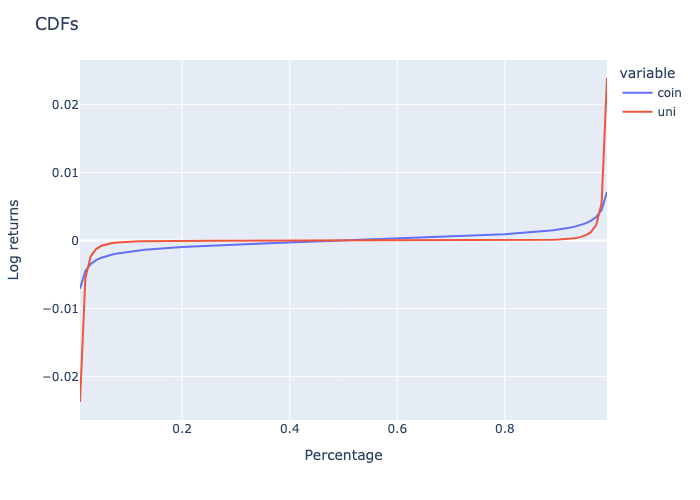

In [91]:
plt = line_chart(dist_df, 'CDFs', 'Percentage', ['coin', 'uni'], 'Percentage', 'Log returns')
plt.show() if interact_chart else Image(plt.to_image(format="png"))

In [65]:
df['uni_log_returns'] = [0] + log_uni
df['coin_log_returns'] = [0] + log_coin


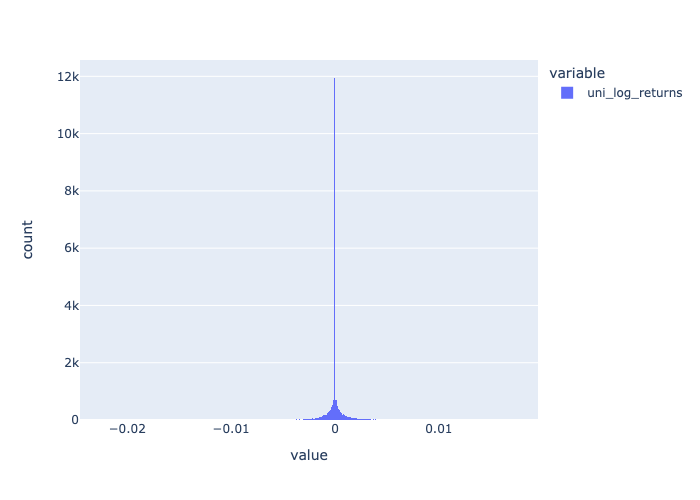

In [96]:
plt = px.histogram(df, x=['uni_log_returns'], nbins=500)
plt.show() if interact_chart else Image(plt.to_image(format="png"))

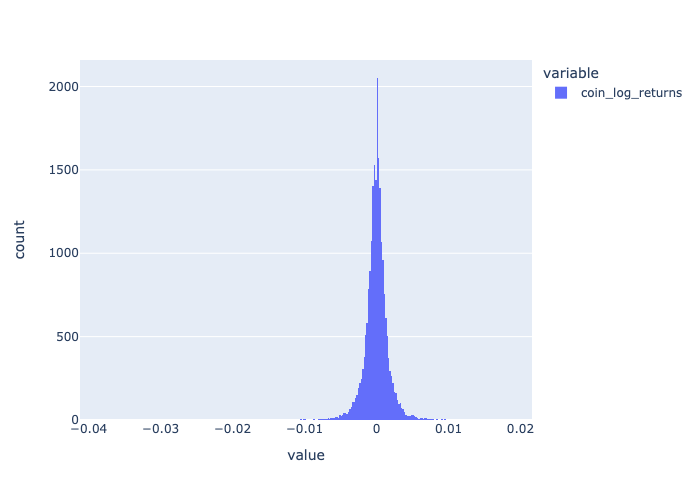

In [98]:
plt = px.histogram(df, x=['coin_log_returns'], nbins=500)
plt.show() if interact_chart else Image(plt.to_image(format="png"))

Uni distribution has way too many zeros. Maybe pystable is not able to fit the distribution. Check qq plot

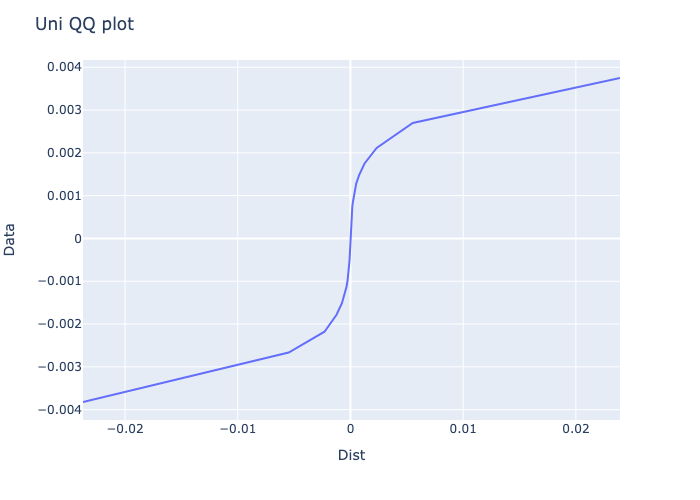

In [99]:
uni_q_data = get_qs_data(log_uni)
plt = line_chart(pd.DataFrame({'data': uni_q_data, 'dist': uni_q}), 'Uni QQ plot', 'dist', 'data', 'Dist', 'Data')
plt.show() if interact_chart else Image(plt.to_image(format="png"))

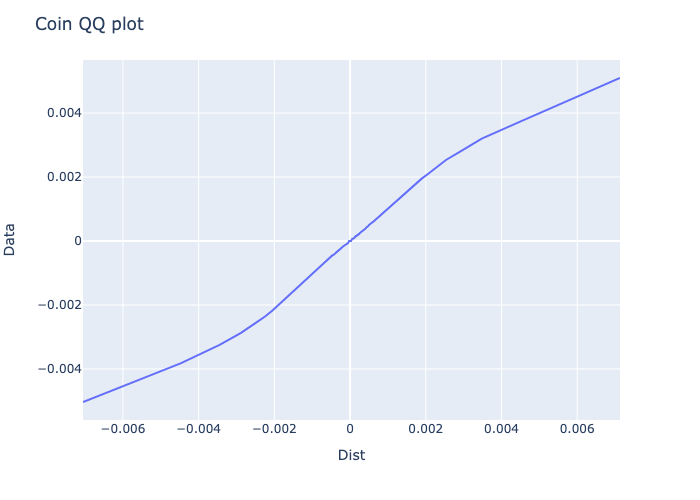

In [100]:
coin_q_data = get_qs_data(log_coin)
plt = line_chart(pd.DataFrame({'data': coin_q_data, 'dist': coin_q}), 'Coin QQ plot', 'dist', 'data', 'Dist', 'Data')
plt.show() if interact_chart else Image(plt.to_image(format="png"))

# Try adding noise

In [70]:
noise_df = df.copy(deep=True)
noise_df = noise_df.iloc[1:,:]  # Remove first row since log returns are NA

In [71]:
noise_df

,time,coin,uni,uni_log_returns,coin_log_returns
1,2022-06-01 00:10:00,16.373312,16.345683,6.177501e-04,0.000573
2,2022-06-01 00:20:00,16.416318,16.351692,3.675261e-04,0.002623
3,2022-06-01 00:30:00,16.397475,16.361773,6.163437e-04,-0.001148
4,2022-06-01 00:40:00,16.388069,16.366600,2.949345e-04,-0.000574
5,2022-06-01 00:50:00,16.362595,16.366600,0.000000e+00,-0.001556
...,...,...,...,...,...
21878,2022-10-30 22:20:00,13.005592,12.995307,0.000000e+00,-0.001692
21879,2022-10-30 22:30:00,12.997141,12.995306,-1.136248e-07,-0.000650
21880,2022-10-30 22:40:00,12.990387,12.995304,-1.136248e-07,-0.000520
21881,2022-10-30 22:50:00,12.971851,12.995304,0.000000e+00,-0.001428


In [72]:
# Found out the percentage difference between uniswap and coinbase prices
noise_df['uni_coin_diff'] = noise_df.uni/noise_df.coin - 1
noise_df

,time,coin,uni,uni_log_returns,coin_log_returns,uni_coin_diff
1,2022-06-01 00:10:00,16.373312,16.345683,6.177501e-04,0.000573,-0.001687
2,2022-06-01 00:20:00,16.416318,16.351692,3.675261e-04,0.002623,-0.003937
3,2022-06-01 00:30:00,16.397475,16.361773,6.163437e-04,-0.001148,-0.002177
4,2022-06-01 00:40:00,16.388069,16.366600,2.949345e-04,-0.000574,-0.001310
5,2022-06-01 00:50:00,16.362595,16.366600,0.000000e+00,-0.001556,0.000245
...,...,...,...,...,...,...
21878,2022-10-30 22:20:00,13.005592,12.995307,0.000000e+00,-0.001692,-0.000791
21879,2022-10-30 22:30:00,12.997141,12.995306,-1.136248e-07,-0.000650,-0.000141
21880,2022-10-30 22:40:00,12.990387,12.995304,-1.136248e-07,-0.000520,0.000379
21881,2022-10-30 22:50:00,12.971851,12.995304,0.000000e+00,-0.001428,0.001808


In [73]:
# Average percentage price difference is expected to be ~0 since basically the prices are very similar
noise_df.uni_coin_diff.mean()

1.8854669752077555e-05

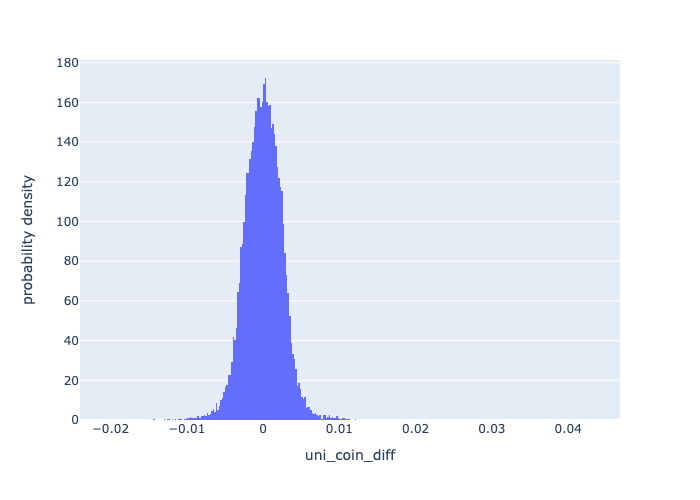

In [102]:
# Plot distribution of price difference. Expected to be gaussian
plt = px.histogram(noise_df, x='uni_coin_diff', nbins=500, histnorm='probability density')
plt.show() if interact_chart else Image(plt.to_image(format="png"))

In [75]:
mean, std_dev = norm.fit(noise_df.uni_coin_diff)
print('Mean =', mean)
print('Std Dev =', std_dev)

Mean = 1.8854669752077555e-05
Std Dev = 0.0025371914816321155


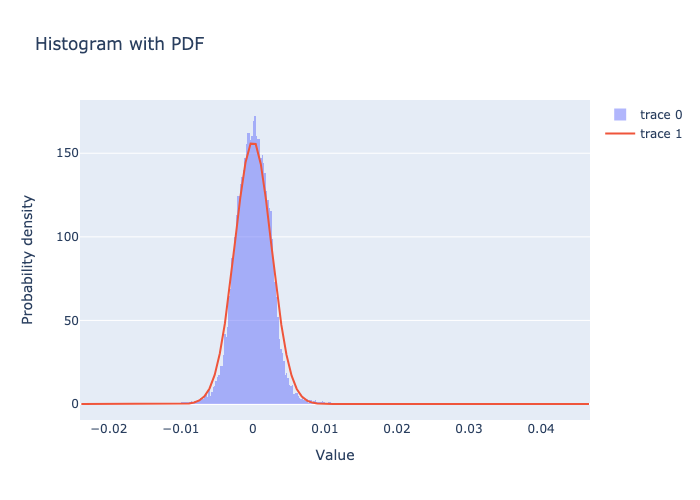

In [103]:
# plot the histogram of the data
histogram = go.Histogram(x=noise_df.uni_coin_diff, nbinsx=500, histnorm='probability density', opacity=0.5)
x = np.linspace(noise_df.uni_coin_diff.min(), noise_df.uni_coin_diff.max(), 100)
pdf = norm.pdf(x, loc=mean, scale=std_dev)
line = go.Scatter(x=x, y=pdf, mode='lines')
fig = go.Figure(data=[histogram, line])

# update the layout
fig.update_layout(title='Histogram with PDF', xaxis_title='Value', yaxis_title='Probability density')

# show the plot
fig.show() if interact_chart else Image(fig.to_image(format="png"))


In [77]:
def gauss_data_point(mean, stddev, thresh):
    lower_bound = mean - thresh*stddev
    upper_bound = mean + thresh*stddev
    point = np.random.normal(loc=mean, scale=std_dev, size=1)
    while (point < lower_bound) | (point > upper_bound):
        point = np.random.normal(loc=mean, scale=std_dev, size=1)
    return point[0]

### Add noise to all uni data points

In [78]:
noise_df['uni_noisy'] = noise_df.uni.apply(
    lambda x: (gauss_data_point(mean, std_dev, 2) + 1) * x
)

In [79]:
noise_df

,time,coin,uni,uni_log_returns,coin_log_returns,uni_coin_diff,uni_noisy
1,2022-06-01 00:10:00,16.373312,16.345683,6.177501e-04,0.000573,-0.001687,16.359104
2,2022-06-01 00:20:00,16.416318,16.351692,3.675261e-04,0.002623,-0.003937,16.371752
3,2022-06-01 00:30:00,16.397475,16.361773,6.163437e-04,-0.001148,-0.002177,16.331046
4,2022-06-01 00:40:00,16.388069,16.366600,2.949345e-04,-0.000574,-0.001310,16.366552
5,2022-06-01 00:50:00,16.362595,16.366600,0.000000e+00,-0.001556,0.000245,16.359504
...,...,...,...,...,...,...,...
21878,2022-10-30 22:20:00,13.005592,12.995307,0.000000e+00,-0.001692,-0.000791,13.015643
21879,2022-10-30 22:30:00,12.997141,12.995306,-1.136248e-07,-0.000650,-0.000141,12.981777
21880,2022-10-30 22:40:00,12.990387,12.995304,-1.136248e-07,-0.000520,0.000379,13.041493
21881,2022-10-30 22:50:00,12.971851,12.995304,0.000000e+00,-0.001428,0.001808,13.040235


In [80]:
log_uni_noisy = log_returns(np.array(noise_df.uni_noisy))

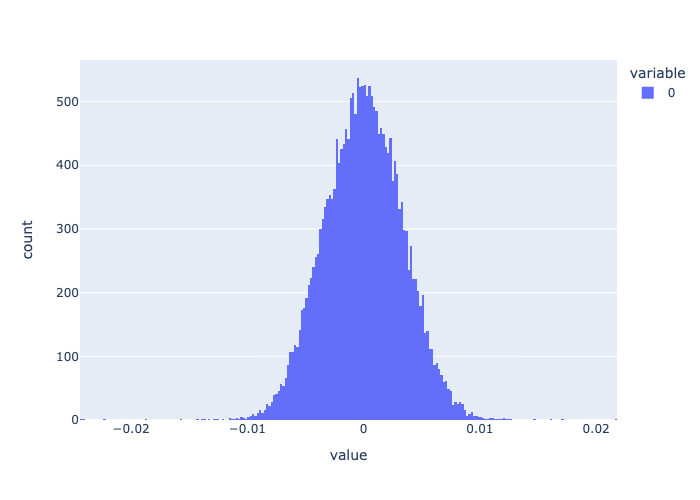

In [104]:
plt = px.histogram(log_uni_noisy)
plt.show() if interact_chart else Image(plt.to_image(format="png"))

### Add noise to only those uni data points that are repeating

In [82]:
noise_df['shift_uni'] = noise_df.uni.shift(1)
noise_df['uni_noisy_v2'] = np.where(
    noise_df.uni == noise_df.shift_uni,
    noise_df.uni.apply(lambda x: (gauss_data_point(mean, std_dev, 2) + 1) * x),
    noise_df.uni
)

In [83]:
noise_df.head()

,time,coin,uni,uni_log_returns,coin_log_returns,uni_coin_diff,uni_noisy,shift_uni,uni_noisy_v2
1,2022-06-01 00:10:00,16.373312,16.345683,0.000618,0.000573,-0.001687,16.359104,NaN,16.345683
2,2022-06-01 00:20:00,16.416318,16.351692,0.000368,0.002623,-0.003937,16.371752,16.345683,16.351692
3,2022-06-01 00:30:00,16.397475,16.361773,0.000616,-0.001148,-0.002177,16.331046,16.351692,16.361773
4,2022-06-01 00:40:00,16.388069,16.366600,0.000295,-0.000574,-0.001310,16.366552,16.361773,16.366600
5,2022-06-01 00:50:00,16.362595,16.366600,0.000000,-0.001556,0.000245,16.359504,16.366600,16.368010


In [84]:
log_uni_noisy_v2 = log_returns(np.array(noise_df.uni_noisy_v2))

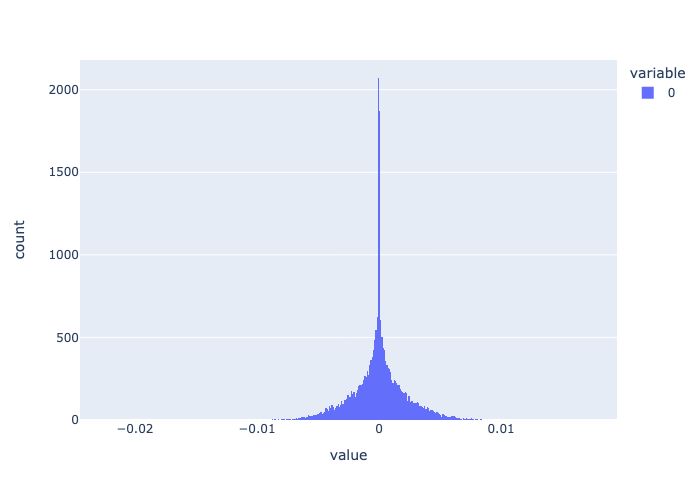

In [109]:
plt = px.histogram(log_uni_noisy_v2, nbins=500, labels='check')
plt.show() if interact_chart else Image(plt.to_image(format="png"))

In [120]:
# Plot all histograms side by side
hist_df = pd.concat([
    df.coin_log_returns,
    df.uni_log_returns,
    pd.Series(log_uni_noisy),
    pd.Series(log_uni_noisy_v2)
], axis =1
)

hist_df.dropna(inplace=True)

hist_df.columns = ['Coinbase raw', 'Uniswap raw',
                   'Uniswap with noise',
                   'Uniswap with noise when no price change']

hist_df = pd.melt(hist_df, var_name='Log returns', value_name='Values')


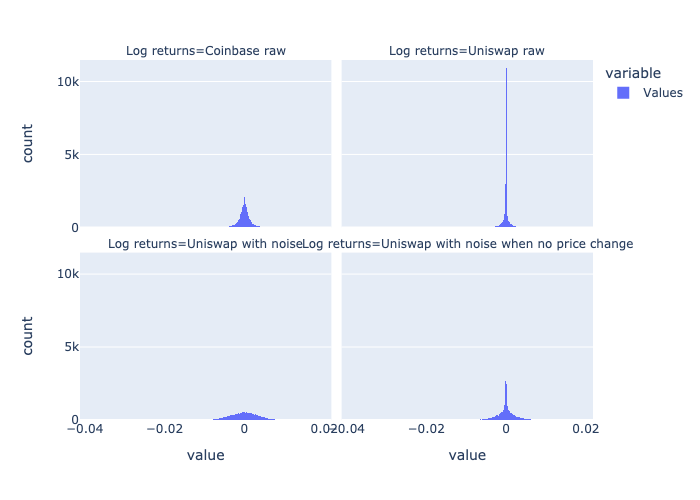

In [122]:
plt = px.histogram(hist_df, nbins=500, facet_col='Log returns', facet_col_wrap=2)
plt.show() if interact_chart else Image(plt.to_image(format="png"))

#### Observations from adding noise
Experiment 1: Adding Gaussian noise to each uniswap price
Observation: Resulting distribution has fewer zeros, but a totally different distribution compared to the coinbase one.

Experiment 2: Adding Gaussin noise to only those uniswap prices which are the same as the previos price
Observation: Resulting distribution has idential amount of zeros! But the rest of the distribution is very different. And the difference is due to the fact that coinbase prices have smaller movements and therefore many points close to 0. While uniswap markets have relatively larger movements and therefore fewer points close to 0.

#### Next steps

Try adding 